# Contents

1. [**Summary**](sec1)
1. [**System Setup**](#sec2)
2. [**Exploratory Data Analysis**](#sec3)
3. [**Logistic Regression**](#sec4)
4. [**Lasso**](#sec5)
5. [**Gradient Boosting**](#sec6)
6. [**PCA**](#sec7)
7. [**Findings**](#sec8)
1. [**Sources**](#sec9)

# 1. Summary <a id='sec1'></a>

The problem we are approching in this report is to perform a dimension reduction on the `red wine` dataset and to build a model with the features selected. In this report we have as objective to find if the dimension reduction is a way to improve models performances. The idea is to use several techniques to select the most important features in order to build a prediction model. The solution we implemented is based on three techniques largely popular among the data science community to select features. In order to conclude on our work we proceed as the following :

- We load and clean the dataset
    - We verified and remove all the rows with missing values and outliers because that can introduce some noise in the data and hurt the performance of the model.
    - We remove all duplicated rows in the dataset (24 in total).
- We perform a base `logistic regression (logreg)` model as a benchmark in order to make the comparison between the diferents dimension reduction techniques that we'll use. `logreg` is specified, tuned and trained with all of the features (11 in our case) and the accuracy and AUC metrics were use to evaluate its performance.
- We perform the dimension reduction using three methods : `Lasso regression (lasso)`, `Gradient bossting (GB)` and `Principal Component Analysis (PCA)` and with each methods we perform the same `logreg` on the features selected by these methods and make the comparison with the base `logreg` model in order to draw a conclusion as whether the reduction of features increase or decrease the performance of the model.
- Given that the target distribution isn't balanced `(Bad : 86%, Good : 14%)`, the accuracy only isn't a reliable metric to evaluate the performance of the model. We decided to use a combination of the `accuracy`, the `area under the curve (AUC)` metrics and the `confusion matrix` to make this evaluation of performance.

As results, we found that the three methods `(Lasso, Gradient Boosting, Principal Components Analysis)` that we used have the same power of prediction `(AUC = 0.89)` as the `base logistic model (logreg)` performed as a benchmark to compare the models performances. Given that we know about the distribution of the target `(quality)` we can easily say that in this case the differences between the three methods is more reflated in the accuracy metric and the confusion matrix (because they have the same power of prediction `AUC = 0.89`) so we have to break it down to have a better understanding of the matter :
- For the Lasso method, the quality of the model is improved as the accuracy comparison proves it : `88.7% for logreg versus 89.5% for lasso`. The confusion matrix shows also that we have an `precision of 70%` in the prediction of the minority class. This method dropped the features : `('free sulfur dioxide'` and `'pH')`.
- We can make the same conclusion as before for the Gradient Boosting (GB) strategy because the accuracy is improved : `88.7% for logreg versus 89.0% for GB` and this method dropped `'residual sugar'` and `pH`. As for the confusion matrix, we have seen that it presents a `precision of 65.5%` in predicting the minority class.
- As for the Pricipal Components Analysis (PCA), the accuracy slightly dropped : `88.7% for logreg versus 88.5% for PCA`. We also conclude with this strategy specifies that nine components is enough to capture the essence of the information contained in the original dataset and this method  we have `60% precision` in the prediction of the minority class.

So with all the results that we have, we can confidently conclude that the dimension reduction that have the benefit to reduce computing time is a great solution in order to improve the models performances. Even if in our case we are not really in high dimension data, these methods prove that they are great help in apraoching the dimension problem and reduce the complexity of the models.

An interesting case that we have not explored and considered as a limit in this report is the difference between the `Lasso` and `GB` methods for the features dropped by them. An explaination for this difference is a case to explore in perpective to be more accurate in the understanding of these methods for features selection in dimension reduction.

# 2. System Setup <a id = 'sec2'></a>

In [1]:

import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, classification_report, plot_roc_curve
from sklearn.preprocessing import StandardScaler
from IPython.display import display
import warnings 
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.pipeline import Pipeline


# 3. Exploratory Data Analysis <a id = 'sec3'></a>

In [3]:
# Data reading
red_wine = pd.read_csv("data/winequality-red.csv", sep=';', delimiter=None, header='infer', names=None, index_col=None, 
                          usecols=None)

In [4]:
display(red_wine.head())
print("Missing values :", red_wine.isna().sum().sum(), "\nDataset dimension :", red_wine.shape)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Missing values : 0 
Dataset dimension : (1599, 12)


In [5]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(red_wine.select_dtypes(include=numerics).columns)
print('Number of numerical variables  : ', len(numerical_vars))
print('='*100)
data = red_wine[numerical_vars]
print('Numerical Variables Columns : \n',numerical_vars)
print('='*100)

Number of numerical variables  :  12
Numerical Variables Columns : 
 ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


In [7]:
red_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [8]:
print('Numbers of duplicated rows : {}'.format(red_wine.duplicated().sum()))
#Removing all the duplicated records
red_wine.drop_duplicates(inplace=True)

Numbers of duplicated rows : 240


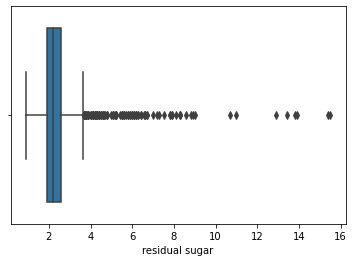

In [10]:
sns.boxplot(x=red_wine['residual sugar']);

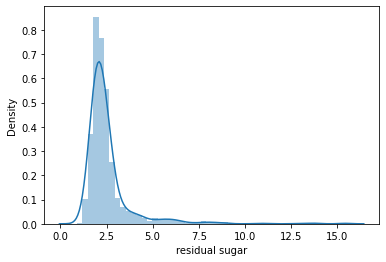

In [11]:
sns.distplot(red_wine['residual sugar']);

Comment : The last two figures proves that the dataset contains outliers and we have to handle them in order to continue.

In [12]:
def outliers(df): 
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numerical_vars = list(df.select_dtypes(include=numerics).columns)
    ff= df.columns
    for i in  numerical_vars :
        Q1=df[i].quantile(0.25)
        Q3=df[i].quantile(0.75)
        IQR = Q3 - Q1
        lower_lim = Q1 - 1.5*IQR
        upper_lim = Q3 - 1.5*IQR
        outlier_low = (df[i] < lower_lim)
        outlier_up =(df[i]> upper_lim)
        no_out= df[(outlier_low |outlier_up )]
    return  no_out

In [13]:
outliers(red_wine)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
5,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1593,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [14]:
round(red_wine.describe(exclude = 'object'), 2).T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1359.0,8.31,1.74,4.60,7.10,7.90,9.20,15.90
volatile acidity,1359.0,0.53,0.18,0.12,0.39,0.52,0.64,1.58
citric acid,1359.0,0.27,0.20,0.00,0.09,0.26,0.43,1.00
residual sugar,1359.0,2.52,1.35,0.90,1.90,2.20,2.60,15.50
chlorides,1359.0,0.09,0.05,0.01,0.07,0.08,0.09,0.61
free sulfur dioxide,1359.0,15.89,10.45,1.00,7.00,14.00,21.00,72.00
total sulfur dioxide,1359.0,46.83,33.41,6.00,22.00,38.00,63.00,289.00
density,1359.0,1.00,0.00,0.99,1.00,1.00,1.00,1.00
pH,1359.0,3.31,0.16,2.74,3.21,3.31,3.40,4.01
sulphates,1359.0,0.66,0.17,0.33,0.55,0.62,0.73,2.00


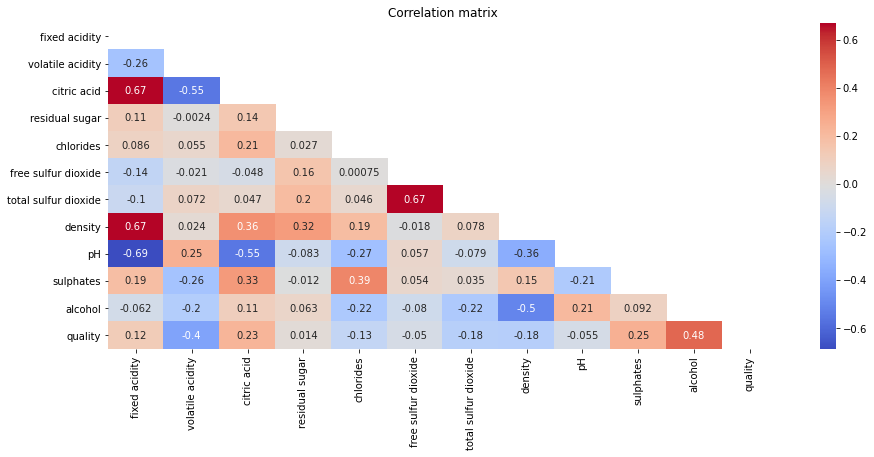

In [15]:
corr_df = red_wine.corr(method='pearson')
plt.figure(figsize=(15, 6))
sns.heatmap(corr_df, annot=True, cmap = "coolwarm", mask = np.triu(corr_df))
plt.title('Correlation matrix')
plt.show()

In [17]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr, threshold
# verifying if there are variables with correlation greater than the threshold
corr_features, threshold = correlation(red_wine, 0.7)
print('{} variable(s) have a correlation superior than : {}.'.format(len(set(corr_features)), threshold))

0 variable(s) have a correlation superior than : 0.7.


In [18]:
#Feature Engineering...
bins = (2, 6.5, 8)
group_names = ['bad', 'good']
red_wine['quality'] = pd.cut(red_wine['quality'], bins = bins, labels = group_names)

#Feature Transformation...
red_wine['quality'].replace({'bad':0, 'good':1}, inplace=True)

In [67]:
print('Distribution of the target in percentage : ')
round(red_wine['quality'].value_counts(normalize=True), 2)

Distribution of the target : 


0    0.86
1    0.14
Name: quality, dtype: float64

In [20]:
print("Shape of the dataset : {}".format(red_wine.shape))

Shape of the dataset : (1359, 12)


# 4. Logistic Regression <a id = 'sec4'></a>

`Logistic regression` is a process of modeling the probability of a discrete outcome given an input variable. The most common logistic regression models a binary outcome; something that can take two values such as true/false, yes/no, and so on. It is a classification model rather than regression model despite its name. Logistic regression is a simple and more efficient method for binary and linear classification problems. It is a classification model, which is very easy to realize and achieves very good performance with linearly separable classes. It is an extensively employed algorithm for classification in industry. The logistic regression model, is a statistical method for binary classification that can be generalized to multiclass classification. 

The model we are performing in this section we'll be use as a benchmark to evaluate the differents methods of dimension reduction that we will use.

In [21]:
# features, training and testing dataset engineering
X, y = red_wine.drop('quality', axis=1), red_wine.quality
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.3)

In [22]:
# Model specification
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

# Hyperparameters specification
params = {
    'model__penalty' : ['l1', 'l2'], 
    'model__C' : np.logspace(-4, 4, 5), 
    'model__solver': ['newton-cg','sag', 'lbfgs']
    }

In [ ]:
# GridSearchCV instanciation
search = GridSearchCV(estimator=pipeline, param_grid=params, cv=10, scoring='neg_mean_squared_error', verbose=1)
search.fit(X_train, y_train)

Logistic Regression best parameters :
 {'model__C': 1.0, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
Logistic Regression final model :
 Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(solver='newton-cg'))])
Fitting to the train set : 0.876
Final model Accuracy : 0.887
Classification report : 
              precision    recall  f1-score   support

           0      0.912     0.963     0.937       354
           1      0.618     0.389     0.477        54

    accuracy                          0.887       408
   macro avg      0.765     0.676     0.707       408
weighted avg      0.873     0.887     0.876       408

Confusion matrix : 


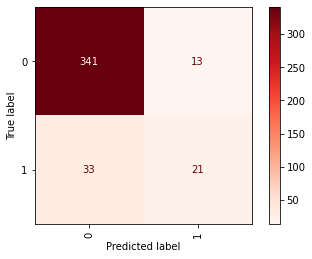

In [24]:
# Logistic regression
print('Logistic Regression best parameters :\n', search.best_params_)
best_logreg_model = search.best_estimator_
print("==============================================================================")
print("Logistic Regression final model :\n", best_logreg_model)
print("==============================================================================")
print('Fitting to the train set : {:04.3f}'.format(best_logreg_model.score(X_train, y_train)))
print("==============================================================================")
score_best_logreg = best_logreg_model.score(X_test, y_test)
print('Final model Accuracy : {:04.3f}'.format(score_best_logreg))
print("==============================================================================")
print("Classification report : ")
best_logreg_pred = best_logreg_model.predict(X_test)
print(classification_report(y_test, best_logreg_pred, 
                            digits=3, zero_division = 1))
print("==============================================================================")
print("Confusion matrix : ")
disp = plot_confusion_matrix(best_logreg_model, X_test, y_test, cmap='Reds', values_format='d',
                            xticks_rotation='vertical')

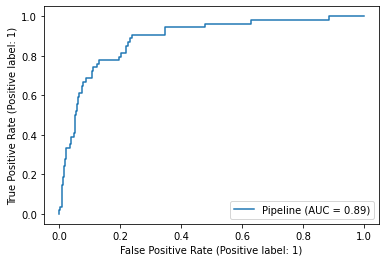

In [25]:
# Plot the ROC curve 
plot_roc_curve(best_logreg_model, X_test, y_test, ax = plt.gca());

Comment : The `accuracy = 88.7%` and the `AUC = 0.89` indicate that the `base logistic regression (logreg) `model performed have a high power of prediction. Given that the distribution of the target `(quality)` isn't balanced, it is important to use other metrics than the accuracy to assess the performance of the model so, we use the `AUC score` because it is more reliable in this case.

# 5. Lasso <a id = 'sec5'></a>

Lasso stands for `Least Absolute Shrinkage and Selection Operator`. It is a type of linear regression that uses `shrinkage`. The shrinkage part is where data values are shrunk towards a central point, like the mean and for the `regularization` part is intended to counter the problem of over fitting. Over fitting becomes a clear menace when there is a large data set with thousands of features and records. Lasso method is use in features selection and use because it can render a sparce matrix of the predictors. That means that it can reduce the coefficient of a feature to zero thus completely eliminating it and hence is better at reducing the variance when the data consists of many insignificant features. It starts with the standard `Ordinary Least Squares` form and add a penalty for model complexity.

Lasso is = Residual Sum of Squares + $\lambda$ * (Sum of the absolute value of the magnitude of coefficients).

$$
\hat{\beta} = \arg \min_\beta\sum_{i=1}^{n}\left (y_i - (\beta_0 + \beta^TX_i)^2 + \lambda\left\|\beta \right\|_2  \right )
$$

- $`\lambda`$ denotes the amount of shrinkage
- $`\lambda = 0`$ implies all features are considered and it is equivalent to the linear regression where only the residual sum of squares are considered to build a predictive model
- $`\lambda = \infty`$ implies no feature is considered i.e, as $\lambda$ closes to infinity it eliminates more and more features
- The bias increases with increase in $\lambda$
- variance increases with decrease in $\lambda$

In our case, our grid of parameters is defined like this :
- $\alpha$ : regulation parameter
- `fit_intercept` : whether or not to include the intercept in the model
- `normalize` : whether or not to nomalize to features by substracting the mean and divising by the $l2 - norm$ 
- `positive` : force the coeficients to be positive or not
- `selection`: choose a random coeficient to update each time or not


In [26]:
# Features and hyperparameters grid engineering
X, y = red_wine.drop('quality', axis=1), red_wine.quality

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso())
])

param = {
    'model__alpha':[.00001, .0001, .001, .01],
    'model__fit_intercept':[True,False],
    'model__normalize':[True,False],
    'model__positive':[True,False],
    'model__selection':['cyclic','random']
    }

In [27]:
# fitting
search = GridSearchCV(estimator=pipeline, param_grid=param, cv=10, scoring='neg_mean_squared_error', verbose=1)
# Training
search.fit(X_train, y_train)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': [1e-05, 0.0001, 0.001, 0.01],
                         'model__fit_intercept': [True, False],
                         'model__normalize': [True, False],
                         'model__positive': [True, False],
                         'model__selection': ['cyclic', 'random']},
             scoring='neg_mean_squared_error', verbose=1)

In [28]:
print('Best parmameters of the model\n {}'.format(search.best_params_))
print('='*100)
coef_0 = search.best_estimator_[1].coef_
print('Coeficients : \n {}'.format(search.best_estimator_[1].coef_))
print('='*100)
print('Total number of features : {}'.format((X_train.shape[1])))
feat = np.array(X.columns)[coef_0 != 0]
print('='*100)
print('{} Features selected by the model : \n {}'.format(len(feat), feat))
print('='*100)
not_feat = np.array(X.columns)[coef_0 == 0]
print('{} Features dropped by the model : \n {}'.format(len(not_feat), not_feat))
print('='*100)

Best parmameters of the model
 {'model__alpha': 0.001, 'model__fit_intercept': True, 'model__normalize': False, 'model__positive': False, 'model__selection': 'random'}
Coeficients : 
 [ 0.05962773 -0.03928784  0.01089208  0.01614095 -0.03552195 -0.
 -0.02008359 -0.05343362 -0.          0.06152995  0.07435172]
Total number of features : 11
9 Features selected by the model : 
 ['fixed acidity' 'volatile acidity' 'citric acid' 'residual sugar'
 'chlorides' 'total sulfur dioxide' 'density' 'sulphates' 'alcohol']
2 Features dropped by the model : 
 ['free sulfur dioxide' 'pH']


In [29]:
print('Overview of the features matrix :')
red_wine[feat].head(10)

Overview of the features matrix :


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,total sulfur dioxide,density,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,34.0,0.9978,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,67.0,0.9968,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,54.0,0.9970,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,60.0,0.9980,0.58,9.8
5,7.4,0.66,0.00,1.8,0.075,40.0,0.9978,0.56,9.4
6,7.9,0.60,0.06,1.6,0.069,59.0,0.9964,0.46,9.4
7,7.3,0.65,0.00,1.2,0.065,21.0,0.9946,0.47,10.0
8,7.8,0.58,0.02,2.0,0.073,18.0,0.9968,0.57,9.5
9,7.5,0.50,0.36,6.1,0.071,102.0,0.9978,0.80,10.5
10,6.7,0.58,0.08,1.8,0.097,65.0,0.9959,0.54,9.2


## Logistic Regression

In [ ]:
# Trainig a logistic regression model with the features choosen by the lasso method
model_logreg = LogisticRegression().fit(X_train[feat], y_train)

In [31]:
# Hyperparameters grid
param_grid_logreg = {
    'penalty' : ['l1', 'l2'], 
    'C' : np.logspace(-4, 4, 5), 
    'solver': ['newton-cg','sag', 'lbfgs']
}

In [ ]:
# logreg
# Instantiate the grid search model
grid_logreg = GridSearchCV(estimator = model_logreg, param_grid = param_grid_logreg, cv = 5, n_jobs=-1)
# Fit the grid search to the data
best_logreg_grid = grid_logreg.fit(X_train[feat], y_train)

Logistic Regression best parameters :
 {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Logistic Regression final model :
 LogisticRegression(solver='newton-cg')
Fitting to the train set : 0.872
Final model Accuracy : 0.895
Base model accuracy : 0.895
Classification report : 
              precision    recall  f1-score   support

           0      0.908     0.977     0.941       354
           1      0.704     0.352     0.469        54

    accuracy                          0.895       408
   macro avg      0.806     0.665     0.705       408
weighted avg      0.881     0.895     0.879       408

Confusion matrix : 


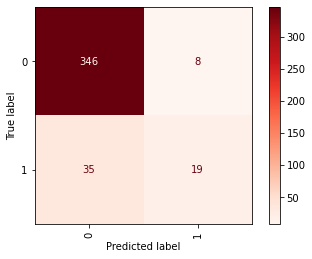

In [33]:
print('Logistic Regression best parameters :\n', best_logreg_grid.best_params_)
best_logreg_model = best_logreg_grid.best_estimator_
print('='*100)
print("Logistic Regression final model :\n", best_logreg_model)
print('='*100)
print('Fitting to the train set : {:04.3f}'.format(best_logreg_model.score(X_train[feat], y_train)))
print('='*100)
score_best_logreg = best_logreg_model.score(X_test[feat], y_test)
print('Final model Accuracy : {:04.3f}'.format(score_best_logreg))
print('='*100)
score_base_logreg = model_logreg.score(X_test[feat], y_test)
print("Base model accuracy : {:04.3f}".format(score_base_logreg))
print('='*100)
print("Classification report : ")
best_logreg_pred = best_logreg_model.predict(X_test[feat])
print(classification_report(y_test, best_logreg_pred, 
                            digits=3, zero_division = 1))
print('='*100)
print("Confusion matrix : ")
disp = plot_confusion_matrix(best_logreg_model, X_test[feat], y_test, cmap='Reds', values_format='d',
                            xticks_rotation='vertical')

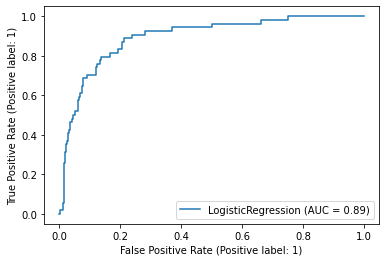

In [34]:
plot_roc_curve(best_logreg_model, X_test[feat], y_test, ax = plt.gca());

Comment : As we expected, the Lasso method have improved the quality of the model :
- For the logistic regression, we had `accuracy (logreg) = 88.7%` and the `AUC = 0.89` and now the `accuracy (lasso) = 89.5%` proves that the reduction of dimension perfomed with the Lasso give a better perdicting output. The model still have the same power of prediction `(AUC (lasso) = AUC (logreg) = 0.89)`.

# 6. Gradient Boosting <a id = 'sec6'></a>



Gradient boosting is a powerful algorithm that can be use to find any nonlinear relationship between your model target and features and has great usability that can deal with missing values, outliers, and high cardinality categorical values on your features without any special treatment. The idea is to test whether a weak learner can be modified to become better. A weak hypothesis or weak learner is defined as one whose performance is at least slightly better than random chance. The formal definition of the Gradient Boosting is given by the computing of :
$$\arg \min_{g \in \varrho }\left\{ \sum_{i=1}^{n} \left [ L \left ( y_i , f^{t-1}(x_i) \right ) + \alpha g(x_i) \right ]\right\}$$

- $L \left ( y_i , f^{t-1}(x) \right ) = (y - f(x))^2$ : quadratic loss
- $g$ : collection of regressors binary trees with depth $L$

We use `RFECV` to perform a cross validation with a boosting classifier with the following parameters :
- `criterion = 'mse'` : minimum of the mean squared error as criterion
- `learning_rate` : shrinkage parameter for the trees
- `n_estimators` : number of boosting stage to perform
- `loss` : loss function, deviance means two times the log likelihood attached to the model

In [35]:
# Cross validation with REFCV to select the model with the better performance
sel_2 =RFECV(GradientBoostingClassifier(criterion="mse",learning_rate=0.1,verbose=-1,n_estimators=200,
                                                loss='deviance',random_state=39), cv=5,scoring='f1_weighted')

In [ ]:
#Trainning
sel_2 = sel_2.fit(X_train, y_train)

In [37]:
feat2 = X_train.columns[(sel_2.get_support())]
print('{} Features selected by the model :\n{}'.format(len(feat2), feat2))

9 Features selected by the model :
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides',
       'free sulfur dioxide', 'total sulfur dioxide', 'density', 'sulphates',
       'alcohol'],
      dtype='object')


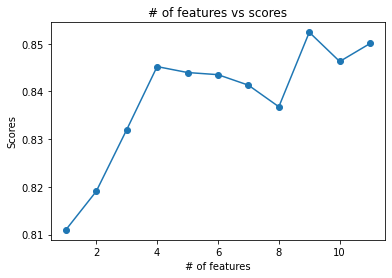

In [38]:
plt.xlabel("# of features")
plt.ylabel("Scores")
plt.plot(range(1, len(sel_2.grid_scores_) + 1), sel_2.grid_scores_, '-o')
plt.title('# of features vs scores');

Comment :  As we have seen the performance of the model is at his peak with these 9 features choosen : `'fixed acidity', 'volatile acidity', 'citric acid', 'chlorides',
       'free sulfur dioxide', 'total sulfur dioxide', 'density', 'sulphates',
       'alcohol'`

## Logistic Regression

In [ ]:
# logreg
# Instantiate the grid search model
grid_logreg = GridSearchCV(estimator = model_logreg, param_grid = param_grid_logreg, cv = 5, n_jobs=-1)
# Fit the grid search to the data
best_logreg_grid = grid_logreg.fit(X_train[feat2], y_train)

In [40]:
# overview of the features matrix choosen by the Gradient Boosting method``
X_test[feat2]

,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,density,sulphates,alcohol
55,7.7,0.620,0.04,0.084,25.0,45.0,0.99780,0.53,9.5
1291,8.2,0.635,0.10,0.073,25.0,60.0,0.99638,0.75,10.9
1544,8.4,0.370,0.43,0.063,12.0,19.0,0.99550,0.81,11.2
593,9.9,0.490,0.58,0.094,9.0,43.0,1.00040,0.58,9.0
1261,6.3,1.020,0.00,0.083,17.0,24.0,0.99437,0.55,11.2
...,...,...,...,...,...,...,...,...,...
1305,7.5,0.610,0.26,0.073,24.0,88.0,0.99612,0.53,9.8
1120,7.9,0.540,0.34,0.076,8.0,17.0,0.99235,0.72,13.1
456,8.9,0.590,0.39,0.095,5.0,22.0,0.99860,0.58,10.3
1076,9.9,0.320,0.56,0.073,3.0,8.0,0.99534,0.73,11.4


Logistic Regression best parameters :
 {'C': 10000.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Logistic Regression final model :
 LogisticRegression(C=10000.0)
Fitting to the train set : 0.868
Final model Accuracy : 0.890
Base model accuracy : 0.868
Classification report : 
              precision    recall  f1-score   support

           0      0.908     0.972     0.939       354
           1      0.655     0.352     0.458        54

    accuracy                          0.890       408
   macro avg      0.781     0.662     0.698       408
weighted avg      0.874     0.890     0.875       408

Confusion matrix : 


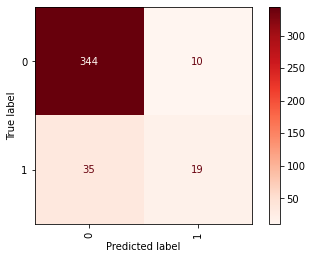

In [41]:
print('Logistic Regression best parameters :\n', best_logreg_grid.best_params_)
best_logreg_model = best_logreg_grid.best_estimator_
print("="*100)
print("Logistic Regression final model :\n", best_logreg_model)
print("="*100)
print('Fitting to the train set : {:04.3f}'.format(best_logreg_model.score(X_train[feat2], y_train)))
print("="*100)
score_best_logreg = best_logreg_model.score(X_test[feat2], y_test)
print('Final model Accuracy : {:04.3f}'.format(score_best_logreg))
print("="*100)
score_base_logreg = model_logreg.score(X_test[feat2], y_test)
print("Base model accuracy : {:04.3f}".format(score_base_logreg))
print("="*100)
print("Classification report : ")
best_logreg_pred = best_logreg_model.predict(X_test[feat2])
print(classification_report(y_test, best_logreg_pred, 
                            digits=3, zero_division = 1))
print("="*100)
print("Confusion matrix : ")
disp = plot_confusion_matrix(best_logreg_model, X_test[feat2], y_test, cmap='Reds', values_format='d',
                            xticks_rotation='vertical')

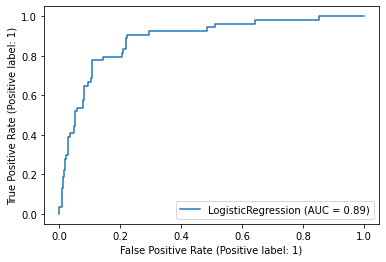

In [42]:
plot_roc_curve(best_logreg_model, X_test[feat2], y_test, ax = plt.gca());

Comment : As we expected, the `Gradient Bossting (GB)` method have improved the quality of the model :
- For the logistic regression, we had `accuracy (logreg) = 88.7%` and the `AUC = 0.89` and now the `accuracy (GB) = 89.0%` proves that the reduction of dimension perfomed with the GB method give a slightly better perdicting output. The model still have the same power of prediction `(AUC (GB) = AUC (logreg) = 0.89)`.

# 7. PCA <a id = 'sec7'></a>

`PCA` is an unsupervised machine learning tool to reduce the dimensionality of the large data set having large numbers of independent variables with collinearity/correlation among themselves. PCA in others terms is used for dimensionality reduction by reducing noise in the given independent variables. The main idea behind PCA is to project the independent features in a lower dimension in such a way that they end up explaining the maximum variance in the given data. The intuition here is not to eliminate but to synthesize a new set of features called `principal components` from the existing set of variables in such a manner that they end up being projected in the direction where there is maximum variance.

One important thing to note about PCA is that it is an unsupervised dimensionality reduction technique, you can cluster the similar data points based on the feature correlation between them without any supervision (or labels).

In [43]:
X, y = red_wine.drop('quality', axis=1), red_wine.quality

In [44]:
def get_models():
    models = {}
    for i in range(1,12):
        steps = [('pca', PCA(n_components=i)), ('m', LogisticRegression())]
        models[str(i)] = Pipeline(steps=steps)
    return models

In [45]:
def evaluate_model(model, X, y):
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=10, n_jobs=-1, error_score='raise')
    return scores

> 1 : -0.135
> 2 : -0.135
> 3 : -0.137
> 4 : -0.141
> 5 : -0.141
> 6 : -0.129
> 7 : -0.127
> 8 : -0.127
> 9 : -0.125
> 10 : -0.126
> 11 : -0.126


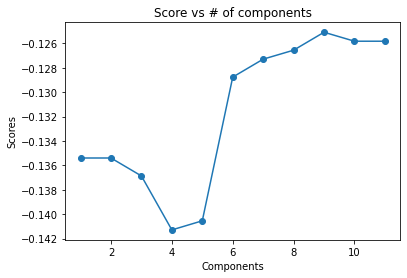

In [46]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names, res = [], [], []
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('> {} : {:.3f}'.format(name, np.mean(scores)))
# plot model performance for comparison
for i in range(0, len(results)):
    mean_i = results[i].mean()
    res.append(mean_i)
plt.plot(range(1, 12, 1), res, '-o')
plt.xlabel('Components')
plt.ylabel('Scores')
plt.title('Score vs # of components');

Comment : Here we have the maximum of the `negative mean squared error (-0.125)` for a total of nine components. Unfortunately we cannot really specify the features because the PCA is a projection of the features dataset and the capture of the essence of the data so the labels are no provided.

## Logistic Regression

In [47]:
# pipeline engineering and specifying a PCA with 9 components
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=9)),
    ('model', LogisticRegression())
])

In [48]:
params = {
    'model__penalty' : ['l1', 'l2'], 
    'model__C' : np.logspace(-4, 4, 5), 
    'model__solver': ['newton-cg','sag', 'lbfgs']
    }

In [ ]:
# cross validation and trainning
search = GridSearchCV(estimator=pipeline, param_grid=params, cv=10, scoring='neg_mean_squared_error', verbose=1)
search.fit(X_train, y_train)

Logistic Regression best parameters :
 {'model__C': 1.0, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
Logistic Regression final model :
 Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=9)),
                ('model', LogisticRegression(solver='newton-cg'))])
Fitting to the train set : 0.872
Final model Accuracy : 0.885
Classification report : 
              precision    recall  f1-score   support

           0      0.912     0.960     0.935       354
           1      0.600     0.389     0.472        54

    accuracy                          0.885       408
   macro avg      0.756     0.675     0.704       408
weighted avg      0.870     0.885     0.874       408

Confusion matrix : 


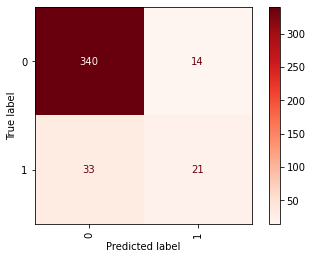

In [50]:
print('Logistic Regression best parameters :\n', search.best_params_)
best_logreg_model = search.best_estimator_
print("==============================================================================")
print("Logistic Regression final model :\n", best_logreg_model)
print("==============================================================================")
print('Fitting to the train set : {:04.3f}'.format(best_logreg_model.score(X_train, y_train)))
print("==============================================================================")
score_best_logreg = best_logreg_model.score(X_test, y_test)
print('Final model Accuracy : {:04.3f}'.format(score_best_logreg))
print("==============================================================================")
print("Classification report : ")
best_logreg_pred = best_logreg_model.predict(X_test)
print(classification_report(y_test, best_logreg_pred, 
                            digits=3, zero_division = 1))
print("==============================================================================")
print("Confusion matrix : ")
disp = plot_confusion_matrix(best_logreg_model, X_test, y_test, cmap='Reds', values_format='d',
                            xticks_rotation='vertical')

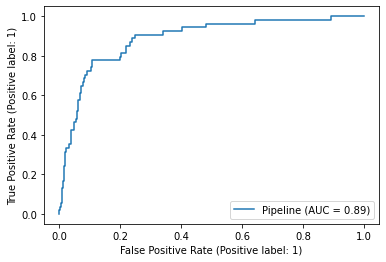

In [51]:
plot_roc_curve(best_logreg_model, X_test, y_test, ax = plt.gca());

Comment : The `Principal Components Analysis (PCA)` method have produced a slightly less performing model :
- For the base logistic regression, we had `accuracy (logreg) = 88.7%` and the `AUC (logreg)= 0.89` and now the `accuracy (PCA) = 88.5%`. We can see that there is a difference of `0.2%` in the accuracy and since the `AUC (PCA) = 0.89` is still the same as `logreg` we can say that this is not a big problem as our level in this report.

# 8. Findings <a id = 'sec8'></a>

We found that the three methods `(Lasso, Gradient Boosting, Principal Components Analysis)` that we used have the same power of prediction `(AUC = 0.89)` as the `base logistic model (logreg)` performed as a benchmark to compare the models performances. Given that the distribution of the target `(quality)`is unbalanced `(Bad : 86%, Good : 14%)` The differences between the three methods is more reflated in the accuracy metric (because they have hte same power of prediction `AUC = 0.89`) so we have to break it down to have a better understanding of the matter :
- For the Lasso method, the quality of the model is improved as the accuracy comparison proves it : `88.7% for logreg versus 89.5% for lasso`. The confusion matrix shows also that we have an `precision of 70%` in the prediction of the minority class. This method dropped the features : `('free sulfur dioxide'` and `'pH')`.
- We can make the same conclusion as before for the Gradient Boosting (GB) strategy because the accuracy is improved : `88.7% for logreg versus 89.0% for GB` and this method dropped `'residual sugar'` and `pH`. As for the confusion matrix, we have seen that it presents a `precision of 65.5%` in predicting the minority class.
- As for the Pricipal Components Analysis (PCA), the accuracy slightly dropped : `88.7% for logreg versus 88.5% for PCA`. We also conclude with this strategy specifies that nine components is enough to capture the essence of the information contained in the original dataset and this method  we have `60% precision` in the prediction of the minority class.

# 9. Sources <a id = "sec9"></a>

- Lasso Regression in Python : https://bit.ly/3sgZO2E
- Lasso and Ridge Regression in R : https://bit.ly/3sihr1N
- Feature Selection by Lasso and Ridge Regression : https://bit.ly/3sh1WXX
- Feature selection : https://scikit-learn.org/stable/modules/feature_selection.html
- Principal Component Analysis for Dimensionality Reduction in Python : https://bit.ly/331aHwY
- Features selection for machine learning : https://bit.ly/3GqsoDB
- gridsearchcv with multiple models Code Example : https://bit.ly/3sh11qI
- Model Selection Using Grid Search : https://bit.ly/3seeTlA
- Understanding AUC - ROC Curve :  https://bit.ly/34dyXfP
- A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning : https://bit.ly/3gDqw05